In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain-openai

In [1]:
import getpass
import os

In [2]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

In [6]:
_set_env("TAVILY_API_KEY")

(Encouraged) [LangSmith](https://smith.langchain.com/) makes it a lot easier to see what's going on "under the hood."

In [2]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

## Time Travel

In a typical chat bot workflow, the user interacts with the bot 1 or more times to accomplish a task. In the previous sections, we saw how to add memory and a human-in-the-loop to be able to checkpoint our graph state and manually override the state to control future responses.

But what if you want to let your user start from a previous response and "branch off" to explore a separate outcome? Or what if you want users to be able to "rewind" your assistant's work to fix some mistakes or try a different strategy (common in applications like autonomous software engineers)?

You can create both of these experiences and more using LangGraph's built-in "time travel" functionality. 

In this section, you will "rewind" your graph by fetching a checkpoint using the graph's `get_state_history` method. You can then resume execution at this previous point in time.

First, recall our chatbot graph. We don't need to make **any** changes from before:

In [7]:
from typing import Annotated, Literal

from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, BaseMessage, ToolMessage
from langchain_core.pydantic_v1 import BaseModel
from typing_extensions import TypedDict

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI()
# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}


graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)


def select_next_node(state: State) -> Literal["human", "tools", "__end__"]:
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(
    checkpointer=memory,
    interrupt_before=["human"],
)

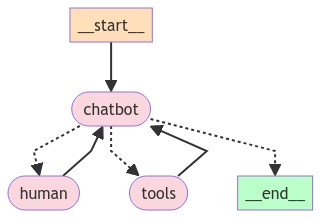

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's have our graph take a couple steps. Every step will be checkpointed in its state history:

In [10]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            ("user", "I'm learning LangGraph. Could you do some research on it for me?")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================

[{'text': "Okay, let's look into LangGraph for you. Here is what I found:", 'type': 'text'}, {'id': 'toolu_011MLMVLrJ9PGFCueNmCf3Rj', 'input': {'query': 'LangGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_011MLMVLrJ9PGFCueNmCf3Rj)
 Call ID: toolu_011MLMVLrJ9PGFCueNmCf3Rj
  Args:
    query: LangGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://github.com/langchain-ai/langgraph", "content": "LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, 

In [11]:
events = graph.stream(
    {
        "messages": [
            ("user", "Ya that's helpful. Maybe I'll build an autonomous agent with it!")
        ]
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

[{'text': 'Great, building an autonomous agent with LangGraph sounds like an exciting project! Here are a few additional thoughts on using LangGraph for that:', 'type': 'text'}, {'id': 'toolu_01EbeNPrWCHdq23ocJyg6nwg', 'input': {'query': 'building autonomous agents with langGraph'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Tool Calls:
  tavily_search_results_json (toolu_01EbeNPrWCHdq23ocJyg6nwg)
 Call ID: toolu_01EbeNPrWCHdq23ocJyg6nwg
  Args:
    query: building autonomous agents with langGraph
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "In this blog, 

Now that we've had the agent take a couple steps, we can `replay` the full state history to see everything that occurred.

In [15]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  8 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  7 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  6 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
-----------------------------------------

**Notice** that checkpoints are saved for every step of the graph. This __spans invocations__ so you can rewind across a full thread's history. We've picked out `to_replay` as a state to resume from. This is the state after the `chatbot` node in the second graph invocation above.

Resuming from this point should call the **action** node next.

In [16]:
print(to_replay.next)
print(to_replay.config)

('tools',)
{'configurable': {'thread_id': '1', 'thread_ts': '1ef355cc-a3fb-65b8-8006-a050e6cf4be7'}}


**Notice** that the checkpoint's config (`to_replay.config`) contains a `thread_ts` **timestamp**. Providing this `thread_ts` value tells LangGraph's checkpointer to **load** the state from that moment in time. Let's try it below:

In [17]:
# The `thread_ts` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://blog.langchain.dev/how-to-build-the-ultimate-ai-automation-with-multi-agent-collaboration/", "content": "In this blog, he walks through how to build an autonomous research assistant using LangGraph with a team of specialized agents. It has only been a year since the initial release of GPT Researcher, but methods for building, testing, and deploying AI agents have already evolved significantly. That's just the nature and speed of the current AI ..."}, {"url": "https://blog.langchain.dev/langgraph-multi-agent-workflows/", "content": "As a part of the launch, we highlighted two simple runtimes: one that is the equivalent of the AgentExecutor in langchain, and a second that was a version of that aimed at message passing and chat models.\n It's important to note that these three examples are only a few of the possible examples we could highlight - there are al

Notice that the graph resumed execution from the `**action**` node. You can tell this is the case since the first value printed above is the response from our search engine tool.

**Congratulations!** You've now used time-travel checkpoint traversal in LangGraph. Being able to rewind and explore alternative paths opens up a world of possibilities for debugging, experimentation, and interactive applications.

## Conclusion

Congrats! You've completed the intro tutorial and built a chat bot in LangGraph that supports tool calling, persistent memory, human-in-the-loop interactivity, and even time-travel!

The [LangGraph documentation](https://langchain-ai.github.io/langgraph/) is a great resource for diving deeper into the library's capabilities.